In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load ComBat algorithm
# !python /content/drive/MyDrive/ABIDE/neuralCombat.py 
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from neuralCombat import *
# from neuralCombat.py import neuralCombat
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection 

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs


In [ ]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
combat = True    # True or False
scaler = True

if combat == False:
  save_combat = '/without_ComBat/'
else:
  save_combat = '/with_ComBat/'

save_path = '/content/drive/MyDrive/ABIDE/save_models/'+fMRI_atlas+ save_combat
root_path = '/content/dataset'
if os.path.exists(root_path):
  shutil.rmtree(root_path) 
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path) 
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

k_fold = 5
new_number_features = 5000
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  print(subject_name)
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]].replace(' ', ''))
    position = position + 1
if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)
	print('Done')

constructing fMRI features
50003
50004
50005
50006
50007
50008
50010
50011
50012
50013
50014
50015
50016
50020
50022
50023
50024
50025
50026
50027
50028
50030
50031
50032
50033
50034
50035
50036
50037
50038
50039
50040
50041
50042
50043
50044
50045
50046
50047
50048
50049
50050
50051
50052
50053
50054
50056
50057
50059
50060
50102
50103
50104
50105
50106
50107
50109
50111
50112
50113
50114
50115
50116
50117
50118
50119
50121
50123
50124
50125
50127
50128
50129
50130
50131
50132
50134
50135
50142
50143
50144
50145
50146
50147
50148
50149
50150
50152
50153
50156
50157
50158
50159
50160
50161
50162
50163
50164
50167
50168
50169
50170
50171
50182
50183
50184
50186
50187
50188
50189
50190
50193
50194
50195
50196
50198
50199
50200
50201
50202
50203
50204
50205
50206
50208
50210
50213
50214
50215
50217
50232
50233
50234
50236
50237
50239
50240
50241
50243
50245
50247
50248
50249
50250
50251
50252
50253
50254
50255
50257
50259
50260
50261
50262
50263
50264
50265
50266
50267
50268
50269
50270
5

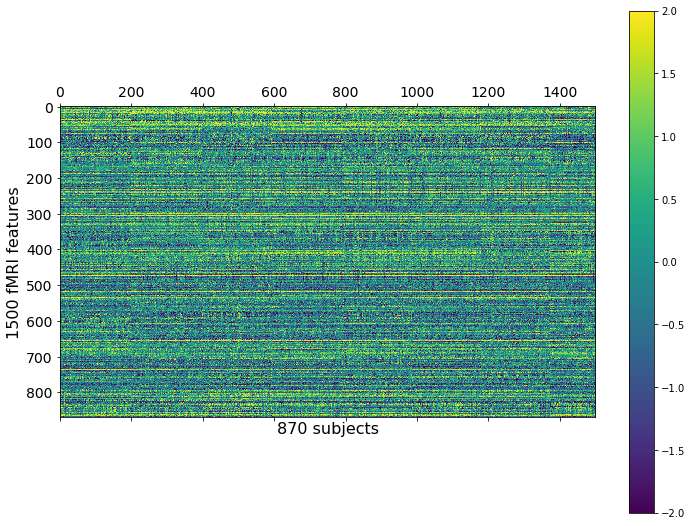

In [ ]:
plt.figure(figsize=(12,9))
plt.matshow(fMRI_images[:,:1500], vmin=-2, vmax=2,fignum=1)
plt.colorbar()
plt.xlabel("870 subjects",fontsize=16)
plt.ylabel("1500 fMRI features",fontsize=16)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

In [ ]:
############################################### Combat ###############################################################
############################################### Combat ###############################################################
############################################### Combat ###############################################################
if combat == True:
	batch = []
	for i in range(len(sites)):
		batch.append(get_index(lst=unique_sites, item=sites[i])[0]+1)

	combat_labels = []
	combat_genders = []
	combat_ages = []
	for i in range(len(labels)):
		combat_labels.append(labels[i] + 1)
		combat_genders.append(genders[i])
		combat_ages.append(ages[i])

	new_all_samples_feature = fMRI_images.T
	covars = {}
	covars['batch'] = batch
	covars['labels'] = combat_labels
	covars['genders'] = combat_genders
	covars['ages'] = combat_ages
	covars = pd.DataFrame(covars)

	# To specify names of the variables that are categorical:
	categorical_cols = ['labels', 'genders']
	# To specify the name of the variable that encodes for the scanner/batch covariate:
	batch_col = 'batch'
	continuous_cols = ['ages']
	# Harmonization step:
	new_all_samples_feature = neuroCombat(dat=new_all_samples_feature,
										  covars=covars,
										  batch_col=batch_col,
										  categorical_cols=categorical_cols,
											continuous_cols=continuous_cols)["data"]
	fMRI_images = new_all_samples_feature.T

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


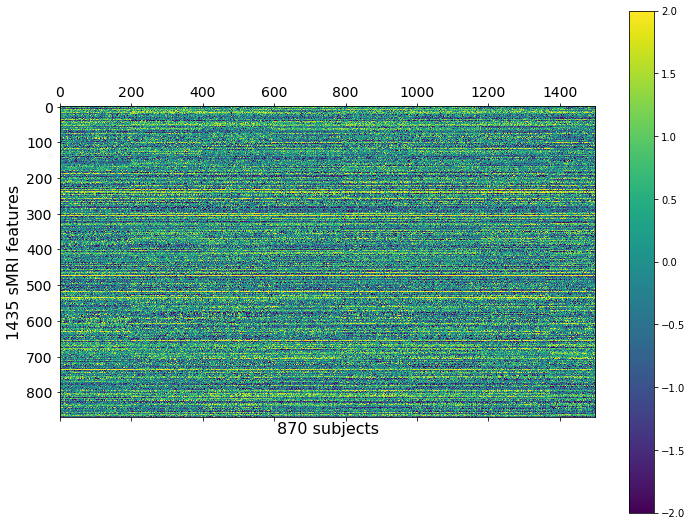

In [ ]:
plt.figure(figsize=(12,9))
plt.matshow(fMRI_images[:,:1500], vmin=-2, vmax=2,fignum=1)
plt.colorbar()
plt.xlabel("870 subjects",fontsize=16)
plt.ylabel("1435 sMRI features",fontsize=16)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

In [ ]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1

In [ ]:
data = {}
for fold in range(1, k_fold+1):
  selector = feature_selection(fMRI_images, labels, dist_train[str(fold)], new_number_features)
  data[str(fold)] = selector.transform(fMRI_images)

Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

Model_1
The proper C is:  1000
The proper gamma is:  scale
validation: accuracy : 0.74175824	
test: accuracy : 0.70056497	
The number of samples in test set is:  177
Model_2
The proper C is:  1000
The proper gamma is:  scale
validation: accuracy : 0.65536723	
test: accuracy : 0.68390805	
The number of samples in test set is:  174
Model_3
The proper C is:  1000
The proper gamma is:  scale
validation: accuracy : 0.72988506	
test: accuracy : 0.62352941	
The number of samples in test set is:  170
Model_4
The proper C is:  1
The proper gamma is:  scale
validation: accuracy : 0.64705882	
test: accuracy : 0.67664671	
The number of samples in test set is:  167
Model_5
The proper C is:  1000
The proper gamma is:  scale
validation: accuracy : 0.67065868	
test: accuracy : 0.68131868	
The number of samples in test set is:  182


The average validation is :  0.6896551724137931
The average test is :  0.6735632183908046
The test AUC is:  0.7420098724236321






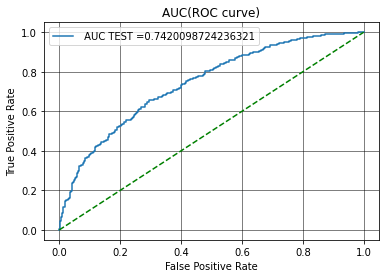

In [ ]:
############################################### Train, validaiton, test ###############################################################
############################################### Train, validaiton, test ###############################################################
############################################### Train, validaiton, test ###############################################################
average_validation = 0
average_test = 0
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 'scale']

for i in range(0, k_fold):
  print('Model_'+ str(i+1))
  ###############################################################################################################
  train_labels = np.zeros((len(dist_train[str(i + 1)]), 1))
  val_labels = np.zeros((len(dist_validation[str(i + 1)]), 1))
  test_labels = np.zeros((len(dist_test[str(i + 1)]), 1))

  train_images = data[str(i+1)][dist_train[str(i+1)],:]
  train_labels = labels[dist_train[str(i + 1)]]
  val_images =  data[str(i+1)][dist_validation[str(i+1)],:]
  val_labels = labels[dist_validation[str(i + 1)]]
  test_images =  data[str(i+1)][dist_test[str(i+1)],:]
  test_labels = labels[dist_test[str(i + 1)]]

  val_special_accuracy = 0
  c_best = 0
  gamma_best=0
  for c_each in C:
    for gamma_each in gamma:
      model_grid = svm.SVC(kernel='rbf', C=c_each, probability=True, random_state=0, gamma=gamma_each)
      model_grid.fit(train_images,train_labels)
      val_results = model_grid.predict(val_images)
      val_accuracy = metrics.accuracy_score(val_labels, val_results)
      # print(val_accuracy)
      if val_special_accuracy<=val_accuracy:
        val_special_accuracy = val_accuracy 
        c_best = c_each
        gamma_best = gamma_each 
  print('The proper C is: ', c_best)
  print('The proper gamma is: ', gamma_best)

  model = svm.SVC(kernel='rbf', C=c_best, probability=True, random_state=0, gamma=gamma_best)
  model.fit(train_images,train_labels)
  val_results = model.predict(val_images)
  val_results_prob = model.predict_proba(val_images)
  test_results = model.predict(test_images)
  test_results_prob = model.predict_proba(test_images)
  joblib.dump(model, save_path + 'SVM_'+str(i+1)+'.m')

  val_accuracy = metrics.accuracy_score(val_labels, val_results)
  test_accuracy = metrics.accuracy_score(test_labels, test_results)
  if i == 0:
    test_labels_concat = test_labels
    test_results_prob_concat = test_results_prob
  else:
    test_labels_concat = np.concatenate((test_labels_concat, test_labels),axis = 0)
    test_results_prob_concat = np.concatenate((test_results_prob_concat, test_results_prob),axis = 0)

  average_validation = val_accuracy * len(val_results) + average_validation
  average_test = average_test + test_accuracy * len(test_results)
  
  print('validation' + ': accuracy : {:.8f}\t'.format(
          val_accuracy))
  print('test'+ ': accuracy : {:.8f}\t'.format(
        test_accuracy))
  print('The number of samples in test set is: ', len(test_results))

average_validation = average_validation / (number_samples - len(useless_samples))
average_test = average_test / (number_samples - len(useless_samples))
print('\n')
print('The average validation is : ', average_validation)
print('The average test is : ', average_test)

test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_results_prob_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The test AUC is: ',test_auc)
print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()



Ensemble  1
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

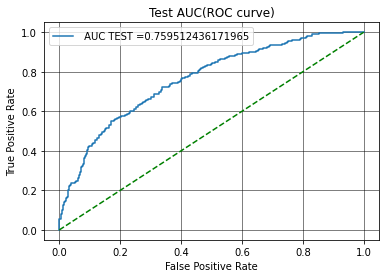

In [ ]:
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/SVM/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1
  


  data = {}
  for fold in range(1, k_fold+1):
    selector = feature_selection(fMRI_images, labels, dist_train[str(fold)], new_number_features)
    data[str(fold)] = selector.transform(fMRI_images)

  ############################################### Train, validaiton, test ###############################################################
  ############################################### Train, validaiton, test ###############################################################
  ############################################### Train, validaiton, test ###############################################################
  val_special_accuracy = 0

  for c_each in C:
    for gamma_each in gamma:
      number_val = 0
      number_test = 0
      fold_validation = []
      fold_test = []
      fold_models = []
      for fold in range(0, k_fold):

        ###############################################################################################################
        model = svm.SVC(kernel='rbf', C=c_each, probability=True, random_state=0, gamma=gamma_each)
        train_labels = np.zeros((len(dist_train[str(fold + 1)]), 1))
        val_labels = np.zeros((len(dist_validation[str(fold + 1)]), 1))
        test_labels = np.zeros((len(dist_test[str(fold + 1)]), 1))

        train_images = data[str(fold+1)][dist_train[str(fold+1)],:]
        train_labels = labels[dist_train[str(fold + 1)]]
        val_images =  data[str(fold+1)][dist_validation[str(fold+1)],:]
        val_labels = labels[dist_validation[str(fold + 1)]]
        test_images =  data[str(fold+1)][dist_test[str(fold+1)],:]
        test_labels = labels[dist_test[str(fold + 1)]]

        model.fit(train_images,train_labels)
        
        val_results = model.predict(val_images)
        val_accuracy = metrics.accuracy_score(val_labels, val_results)
        number_val = number_val + len(val_results)
        fold_validation.append(val_accuracy * len(val_results))

        test_results = model.predict(test_images)
        test_accuracy = metrics.accuracy_score(test_labels, test_results)
        test_results_prob = model.predict_proba(test_images)
        number_test = number_test + len(test_results)
        fold_test.append(test_accuracy * len(test_results))

        fold_models.append(model)

        if fold == 0:
          test_results_plus = test_results
          test_results_prob_plus = test_results_prob
        else:
          test_results_plus = test_results_plus + test_results
          test_results_prob_plus = test_results_prob_plus + test_results_prob

      average_validation = sum(fold_validation)/number_val
      average_test = sum(fold_test)/number_test

      if val_special_accuracy <= average_validation:
        val_special_accuracy = average_validation 
        c_best = c_each
        gamma_best = gamma_each
        corresponding_test_accuracy = average_test
        corresponding_test_results_plus = test_results_plus
        corresponding_test_results_prob_plus = test_results_prob_plus
        joblib.dump(fold_models[0], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(1)+'.m')
        joblib.dump(fold_models[1], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(2)+'.m')
        joblib.dump(fold_models[2], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(3)+'.m')
        joblib.dump(fold_models[3], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(4)+'.m')
        joblib.dump(fold_models[4], save_ensemble_models_path + 'SVM_ensemble'+ str(ensemble_fold) + '_' + str(5)+'.m')
  
  print('The proper C is: ', c_best)
  print('The proper gamma is: ', gamma_best)
  print('The average validation accuracy is: ',val_special_accuracy)
  print('The average test accuracy is: ',corresponding_test_accuracy)
  print('The number of samples in test set is: ',len(test_results))
  dist_ensemble_test_label[str(ensemble_fold+1)] = test_labels
  dist_ensemble_test_result[str(ensemble_fold+1)] = corresponding_test_results_plus
  dist_ensemble_test_prob[str(ensemble_fold+1)] = corresponding_test_results_prob_plus


test_labels_concat = np.concatenate((dist_ensemble_test_label['1'], dist_ensemble_test_label['2'],  dist_ensemble_test_label['3'], dist_ensemble_test_label['4'], dist_ensemble_test_label['5']),axis = 0)
test_results_concat = np.concatenate((dist_ensemble_test_result['1'], dist_ensemble_test_result['2'],  dist_ensemble_test_result['3'], dist_ensemble_test_result['4'], dist_ensemble_test_result['5']),axis = 0)
test_probs_concat = np.concatenate((dist_ensemble_test_prob['1'], dist_ensemble_test_prob['2'],  dist_ensemble_test_prob['3'], dist_ensemble_test_prob['4'], dist_ensemble_test_prob['5']),axis = 0)

test_results_concat[test_results_concat<2.5] = 0
test_results_concat[test_results_concat>=2.5] = 1
test_probs_concat = test_probs_concat/5


test_accuracy = metrics.accuracy_score(test_labels_concat, test_results_concat)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_probs_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('\n')
print('The Max voting test accuracy is: ',test_accuracy)
print('The test AUC is: ',test_auc)

print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

